# Implementation of variational classifier with Qiskit

We attempt to classify the adhoc dataset from Qiskit's machine learning datasets by designing a quantum circuit

1. Randomly sample data into two set for training and testing. We select datapoints of 2 features from each class.

In [1]:
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 3142

import numpy as np
np.random.seed(algorithm_globals.random_seed)

from qiskit_machine_learning.datasets import ad_hoc_data

train_data, train_labels, test_data, test_labels= (
    ad_hoc_data(training_size=20, test_size=5, n=2, gap=0.3, one_hot=False))

2. Create a data encoding circuit with Qiskit's ZZ FeatureMap as data encoding circuit.

In [2]:
from qiskit.circuit.library import ZZFeatureMap 

enc_circuit = ZZFeatureMap(feature_dimension=2, reps=2)

3. Create a variational circuit with Qiskit's TwoLocal circuit with Y and Z rotations with controlled phase gates.

In [3]:
from qiskit.circuit.library import TwoLocal

var_circuit = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

4. Combine the two circuits to obtain the final circuit.

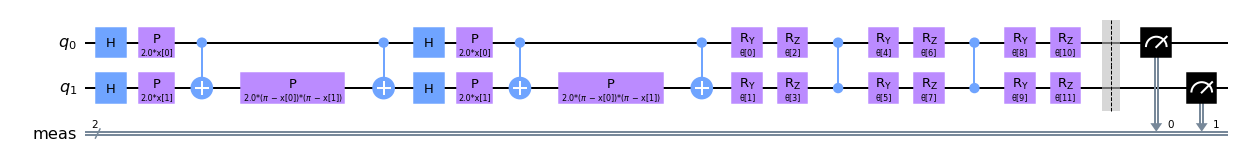

In [4]:
circuit = enc_circuit.compose(var_circuit)
circuit.measure_all()
circuit.decompose().draw(output='mpl')

5. Create the following functions:
    1. `circuit_parameters` associates data to feature map and varaitional parameters to varaitional circuit.
    2. `assign_label` assigns lable to a data point based on its bit string.
    3. `label_probability` returns the probability distribution over the label 0,1.

In [5]:
def circuit_parameters(data, variational):
    parameters = {}
    for i, p in enumerate(enc_circuit.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(var_circuit.ordered_parameters):
        parameters[p] = variational[i]
    return parameters

def assign_label(bitstring):
    parity_sum = sum([int(k) for k in list(bitstring)])
    if parity_sum % 2:
        return 0
    else:
        return 1

def label_probability(results):
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = assign_label(bitstring)
        probabilities[label] += counts / shots
    return probabilities

6. Create a function that classsifies a data point.

In [6]:
from qiskit import BasicAer, execute

def classification_probability(data, variational):
    circuits = [circuit.assign_parameters(circuit_parameters(d,variational)) for d in data]
    backend = BasicAer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    classification = [label_probability(results.get_counts(c)) for c in circuits]
    return classification

7. Create loss and cost functions for training data

In [7]:
def cross_entropy_loss(predictions, expected):
    p = predictions.get(expected)
    return -(expected*np.log(p)+(1-expected)*np.log(1-p))
   
def cost_function(data, labels, variational):
    classifications = classification_probability(data, variational)

    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)

    return cost

8. Use SPSA as out classical optimizer and train the model.

In [8]:
def store_intermediate_result(evaluation, parameter, cost, 
                              stepsize, accept):
    evaluations.append(evaluation)
    parameters.append(parameter)
    costs.append(cost)

from qiskit.algorithms.optimizers import SPSA

parameters = []
costs = []
evaluations = []

optimizer = SPSA(maxiter=100, callback=store_intermediate_result)

initial_point = np.random.random(var_circuit.num_parameters)

objective_function = lambda variational: cost_function(train_data,
                                                       train_labels,
                                                       variational)

opt_var, opt_value, _ = optimizer.optimize(len(initial_point), objective_function, initial_point=initial_point)

9. Plot the graph of cost vs iterations.

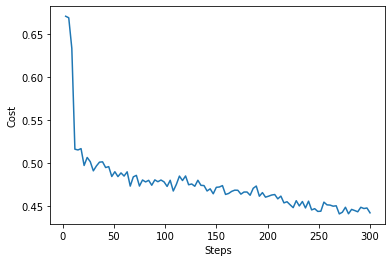

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()